In [1]:
import os
import re
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
output_dir

'/data/estorrs/mushroom/data/projects/submission_v1/analysis/dataset_summary'

In [177]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [178]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [179]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [180]:
import shutil

In [181]:
# # copy to new directory for easy reading locally with napari
# for fp in fps:
#     case = fp.split('/')[-3]
#     level = int(re.sub(r'^.*nbhd_volumes_l([0-9]+).pkl$', r'\1', fp))
    
#     shutil.copy(fp, os.path.join(output_dir, 'volumes', f'{case}_l{level}_volumes.pkl'))

In [182]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [187]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [188]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906'])

In [189]:
case_meta = pd.read_csv(os.path.join(output_dir, 'case_metadata.txt'), sep='\t')
case_meta = case_meta[[True if x not in exclude else False for x in case_meta['case']]]
case_meta['n_sections'] = [len(case_to_sections[x]) for x in case_meta['case']]
    
case_meta

,case,tissue_type,cohort,n_sections
1,C3L-00982,CCRCC,inhouse,5
2,C3L-01287,CCRCC,inhouse,2
3,C3L-02551,CCRCC,inhouse,5
4,HT206B1,BRCA,inhouse,15
5,HT225C1,CRC,inhouse,4
6,HT268B1,BRCA,inhouse,4
7,HT339B2-H1,BRCA,inhouse,2
8,HT397B1,BRCA,inhouse,12
9,HT413C1-K2,CRC,inhouse,2
10,HT413C1-Th1k4A1,CRC,inhouse,28


In [190]:
case_order = case_meta.sort_values(['tissue_type', 'n_sections'])['case'].to_list()
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [197]:
case_to_sections['HT565B1-H2']

[{'data': [{'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s0_HT565B1-H2-U1_visium.h5ad'},
   {'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s0_HT565B1-H2-U1_he.tif'}],
  'position': 0,
  'sid': 'HT565B1-H2-U1'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s1_HT565B1-H2-U2_multiplex.ome.tiff'}],
  'position': 0,
  'sid': 'HT565B1-H2-U2'}]

In [191]:
data = []
for case, sections in case_to_sections.items():
    for entry in sections:
        dtypes = [mapping['dtype'] for mapping in entry['data']]
        if 'visium' in dtypes:
            data.append([case, entry['sid'], entry['position'], 'visium'])
        else:
            for mapping in entry['data']:
                data.append([case, entry['sid'], entry['position'], mapping['dtype']])
df = pd.DataFrame(data=data, columns=['case', 'section_id', 'position', 'dtype'])
df['dtype'] = [x if 'batch' not in x else 'he' for x in df['dtype']]
df

,case,section_id,position,dtype
0,C3L-00982,C3L-00982-U1,0,multiplex
1,C3L-00982,C3L-00982-U2,5,xenium
2,C3L-00982,C3L-00982-U4,15,multiplex
3,C3L-00982,C3L-00982-U5,20,he
4,C3L-00982,C3L-00982-U7,30,multiplex
...,...,...,...,...
109,S18-9906,S18-9906-U17,120,xenium
110,S18-9906,S18-9906-U18,125,multiplex
111,S18-9906,S18-9906-U20,135,he
112,S18-9906,S18-9906-U24,155,xenium


In [192]:
order = ['he', 'visium', 'multiplex', 'xenium', 'cosmx']
dtype_to_color = {
    k:sns.color_palette()[i] for i, k in enumerate(order)
}
dtype_to_color = {
    k:'#%02x%02x%02x' % tuple([int(x * 255.) for x in v]) for k, v in dtype_to_color.items()
}
domain = order
domain_range = [dtype_to_color[dt] for dt in order]

In [248]:
import altair as alt
alt.Chart(df).mark_tick().encode(
    y=alt.Y('case', sort=case_order),
    x=alt.X('position', scale=alt.Scale(reverse=False)),
    color=alt.Color('dtype').scale(domain=domain, range=domain_range)
).configure_tick(
    thickness=5,
    opacity=1.,
    strokeWidth=1,
    stroke='gray',
#     bandSize=10,
)

alt.Chart(...)

In [219]:
alt.Chart(case_meta).mark_rect().encode(
    y=alt.Y('case', sort=case_order),
    color=alt.Color('tissue_type').scale(scheme="set2")
)

alt.Chart(...)

In [220]:
alt.Chart(case_meta).mark_rect().encode(
    y=alt.Y('case', sort=case_order),
    color=alt.Color('cohort').scale(scheme="dark2")
)

alt.Chart(...)

In [222]:
alt.Chart(case_meta).mark_bar().encode(
    y=alt.Y('case', sort=case_order),
    x=alt.X('n_sections'),
#     color=alt.Color('cohort')
)

alt.Chart(...)

In [198]:
data = []
for case, sections in case_to_sections.items():
    dtypes = [mapping['dtype'] for entry in sections for mapping in entry['data']]
    dtypes = sorted(set([dtype for dtype in dtypes if 'batch' not in dtype]))
    
    for dtype in dtypes:
        
        data.append([case, case_order.index(case), dtype])
#             data.append([f'{case}', dtype])
source = pd.DataFrame(data=data, columns=['case', 'case_order', 'dtype'])
order = source.sort_values(['case_order', 'dtype'])['case'].to_list()
source

,case,case_order,dtype
0,C3L-00982,6,he
1,C3L-00982,6,multiplex
2,C3L-00982,6,xenium
3,C3L-01287,5,multiplex
4,C3L-01287,5,xenium
5,C3L-02551,7,he
6,C3L-02551,7,multiplex
7,C3L-02551,7,xenium
8,HT206B1,4,he
9,HT206B1,4,multiplex


In [247]:
c = alt.Chart(source).mark_circle(size=120).encode(
    y=alt.Y('case', sort=order),
    x=alt.X('dtype', sort=['he', 'visium', 'multiplex', 'xenium', 'cosmx']),
    color=alt.Color('dtype').scale(domain=domain, range=domain_range)
).configure_circle(
#     thickness=2.6,
    opacity=1.,
    stroke='gray',
    strokeWidth=1
#     bandSize=10,
)
c

alt.Chart(...)

In [200]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [201]:
case_to_level_to_volume = {}
for fp in fps:
    case = fp.split('/')[-3]
    level = int(re.sub(r'^.*nbhd_volumes_l([0-9]+).pkl$', r'\1', fp))
    
    if case not in exclude:

        if case not in case_to_level_to_volume:
            case_to_level_to_volume[case] = {}
        case_to_level_to_volume[case][level] = fp

In [202]:
# fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/outputs.pkl$'))
# case_to_hierarchy = {}
# for fp in fps:
#     case = fp.split('/')[-3]
#     case_to_hierarchy[case] = pickle.load(open(fp, 'rb'))['dtype_to_cluster_to_agg']


In [268]:
fps = sorted(utils.listfiles(project_dir, regex=r'masks/tissue_mask.tif$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/masks/tissue_mask.tif',
 '/data/estorrs/mushroom/data/projects/subm

In [269]:
# masks_dir = os.path.join(output_dir, 'masks')
# Path(masks_dir).mkdir(parents=True, exist_ok=True)
# for fp in fps:
#     case = fp.split('/')[-3]
#     shutil.copy(fp, os.path.join(masks_dir, f'{case}_tissue_mask.tif'))

In [204]:
case_to_mask = {}
for fp in fps:
    case = fp.split('/')[-3]
    case_to_mask[case] = fp

In [278]:
from collections import Counter
case_to_disease = {c:d for c, d in zip(case_meta['case'], case_meta['tissue_type'])}
diseases = sorted(set(case_meta['tissue_type']))
max_count = Counter(case_meta['tissue_type']).most_common()[0][1]
diseases, max_count

(['BRCA', 'CCRCC', 'CRC', 'PDAC', 'PKD'], 5)

1 0
1 1
1 2
0 0
2 0
0 1
0 2
0 3
2 1
2 2
2 3
3 0
0 4
4 0
4 1


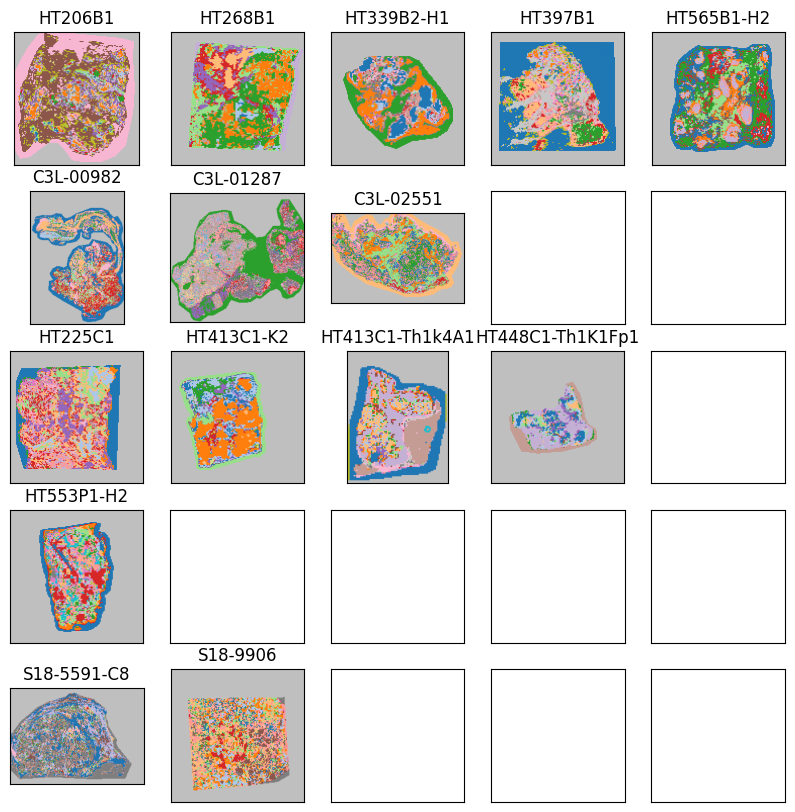

In [287]:
level = 2

nrows = max_count
ncols = len(diseases)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2))
spots = np.zeros((len(diseases),), dtype=int)
for case, l2v in case_to_level_to_volume.items():
    dtype_to_volume = pickle.load(open(l2v[level], 'rb'))['labeled']
    if 'integrated' in dtype_to_volume:
        r = diseases.index(case_to_disease[case])
        c = spots[r]
        print(r, c)
        spots[r] += 1

        ax = axs[r, c]
        volume = dtype_to_volume['integrated']

        mask = tifffile.imread(case_to_mask[case])
        target_size = (volume.shape[1], volume.shape[2])
        mask = utils.rescale(mask, size=target_size, dim_order='h w', target_dtype=bool)

        idx = (volume.shape[0] // 2) - 1
        labels = volume[idx]
        labels[~mask] = volume.max() + 1
        cmap = vis_utils.get_cmap(len(np.unique(volume)))
        rgb = vis_utils.display_labeled_as_rgb(labels, cmap=cmap, preserve_indices=True)
        rgb[~mask] = (.75,.75,.75)
#         rgb[~mask] = (1,1,1)
        ax.imshow(rgb)
        ax.set_title(case)

#         vis_utils.display_legend(np.unique(volume), cmap=cmap, ax=axs[i, 1])

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(os.path.join(output_dir, 'slices.svg'), dpi=300)

In [282]:
# level = 2
# # nrows = len(case_to_level_to_volume)
# # ncols = 2
# # nrows, ncols = 5, 3
# nrows = max_count
# ncols = len(diseases)
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2))
# # slots = rearrange(np.stack(np.meshgrid(np.arange(nrows), np.arange(ncols))), 'b h w -> (h w) b')
# for (r, c), (case, l2v) in zip(slots, case_to_level_to_volume.items()):
#     dtype_to_volume = pickle.load(open(l2v[level], 'rb'))['labeled']
#     if 'integrated' in dtype_to_volume:
#         ax = axs[r, c]
#         volume = dtype_to_volume['integrated']

#         mask = tifffile.imread(case_to_mask[case])
#         target_size = (volume.shape[1], volume.shape[2])
#         mask = utils.rescale(mask, size=target_size, dim_order='h w', target_dtype=bool)

#         idx = (volume.shape[0] // 2) - 1
#         labels = volume[idx]
#         labels[~mask] = volume.max() + 1
#         cmap = vis_utils.get_cmap(len(np.unique(volume)))
#         rgb = vis_utils.display_labeled_as_rgb(labels, cmap=cmap, preserve_indices=True)
#         rgb[~mask] = (.7, .7, .7)
#         ax.imshow(rgb)
#         ax.set_title(case)

# #         vis_utils.display_legend(np.unique(volume), cmap=cmap, ax=axs[i, 1])

# for ax in axs.flatten():
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# plt.savefig(os.path.join(output_dir, 'slices.svg'), dpi=300)

In [261]:
os.path.join(output_dir, 'slices.svg')

'/data/estorrs/mushroom/data/projects/submission_v1/analysis/dataset_summary/slices.svg'

In [207]:
# del(mushroom)

In [208]:
mushroom = Mushroom.from_config(
    '/data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/mushroom_50res', accelerator='cpu')


INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U1', 'HT448C1-Th1K1Fp1-U13']
INFO:root:processing sections
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U1


0.007292096259888302


INFO:root:generating image data for section HT448C1-Th1K1Fp1-U13
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U1', 'he'), ('HT448C1-Th1K1Fp1-U13', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/mushroom_50res/he_chkpts/last-v1.ckpt


he torch.Size([3, 135, 134])


INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 17 channels
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U2', 'HT448C1-Th1K1Fp1-U14']
INFO:root:processing sections
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U2


0.007292096259888302


INFO:root:generating image data for section HT448C1-Th1K1Fp1-U14
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U2', 'multiplex'), ('HT448C1-Th1K1Fp1-U14', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/mushroom_50res/multiplex_chkpts/last-v1.ckpt


multiplex torch.Size([17, 135, 134])


INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing
INFO:root:using 11351 channels
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U1', 'HT448C1-Th1K1Fp1-U13']
INFO:root:processing sections


ppm 0.3646048129944151 target_ppm 100
tiling size 274


INFO:root:generating image data for section HT448C1-Th1K1Fp1-U1
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U13
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([11351, 68, 68])


INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U1', 'visium'), ('HT448C1-Th1K1Fp1-U13', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/mushroom_50res/visium_chkpts/last-v1.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of t

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

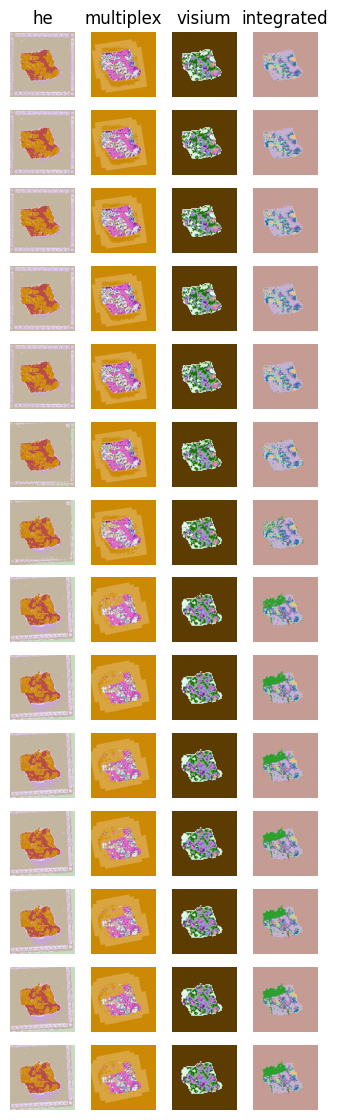

In [210]:
mushroom.display_volumes(level=2)

In [147]:
case = 'C3L-00970'
level = 2

volume = pickle.load(open(case_to_level_to_volume[case][level], 'rb'))['labeled']['integrated']
volume.shape

(2, 236, 220)

In [151]:
mask = tifffile.imread(case_to_mask[case])
target_size = (volume.shape[1], volume.shape[2])
mask = utils.rescale(mask, size=target_size, dim_order='h w', target_dtype=bool)
mask.shape

(236, 220)

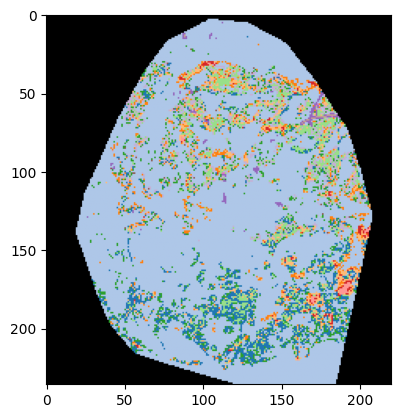

In [153]:
idx = volume.shape[0] // 2
labels = volume[idx]
rgb = vis_utils.display_labeled_as_rgb(labels, cmap=sns.color_palette('tab20'), preserve_indices=True)
rgb[~mask] = (0, 0, 0)
plt.imshow(rgb)

In [11]:
outputs = pickle.load(open(os.path.join(project_dir, 'HT206B1', 'mushroom_50res', 'outputs.pkl'), 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [13]:
dtype_to_volume = pickle.load(
    open(os.path.join(project_dir, 'HT206B1', 'mushroom_50res', 'nbhd_volumes_l2.pkl'), 'rb'))
dtype_to_volume.keys()

dict_keys(['probs', 'labeled'])

In [14]:
dtype_to_volume['labeled'].keys()

dict_keys(['he', 'multiplex', 'xenium', 'integrated'])